In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.stats import ortho_group

from contrastive import CPCA
import string

import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt

from functools import reduce
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Helpers 
def standardize(x): 
    """
    Convert the columns of X to z-scores
    """
    standardized_array =  (x-np.mean(x,axis=0)) / np.std(x, axis=0)
    
    return np.nan_to_num(standardized_array)

def normalize(v):
    return v / np.linalg.norm(v)

def rotate_points_2d(points, degrees):
    """
    Rotate 2D points counterclockwise by a given angle in degrees.

    Parameters:
        points : np.ndarray of shape (N, 2)
            Each row is a 2D point [x, y].
        degrees : float
            Angle to rotate points, in degrees.

    Returns:
        np.ndarray of shape (N, 2)
            Rotated points.
    """
    theta = np.deg2rad(degrees)  # convert degrees to radians
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return points @ rotation_matrix.T  # dot with transpose for row vectors

Define functions to fit rhoPCA and project input data 

In [3]:
def fit_rayleigh_quotient(
    target, background, 
    *, 
    dimension=None
):
    sigma_fg = np.cov(target, rowvar=False)
    sigma_bg = np.cov(background, rowvar=False)

    # Rayleigh quotient generalized eigenproblem
    eigvals, eigvecs = eigh(sigma_fg, sigma_bg)

    if dimension is not None: 
        eigvals_order = np.argsort(-eigvals)
        top_d = eigvals_order[:dimension]

        eigvals = eigvals[top_d]
        eigvecs = eigvecs[:,top_d]

    return eigvals, eigvecs
    
def project_rayleigh_quotient(
    target, background, 
    *, 
    dimension=2,
    return_eigh=False
):
    
    eigvals, eigvecs = fit_rayleigh_quotient(
        target=target, background=background, dimension=dimension)
    
    target_proj = target @ eigvecs 
    background_proj = background @ eigvecs

    if return_eigh:
        return target_proj, background_proj, eigvals, eigvecs
    else: 
        return target_proj, background_proj

In [4]:
def run_pca_simulation(
    target, background, 
    *,
    method = "rayleigh",
    std_transform = True,
    n_alphas_to_try = 10,
    alphas_to_try = np.logspace(-1, 3, 10), 
    rotations = [0]
):
    results = {}
    add_alpha = False
    for rot in rotations: 
        
        if rot != 0:
            background_rot = rotate_points_2d(background, rot)
        else: 
            background_rot = background

        if std_transform: 
            target = standardize(target)
            background_rot = standardize(background_rot)
            
        if method == "rayleigh":
            trg_proj, bck_proj = project_rayleigh_quotient(target, background_rot)
            
        elif method == "cpca":
            mdl = CPCA(verbose=True, standardize=~std_transform)
            mdl.fit(target, background_rot)

            fg = mdl.__dict__["fg"]
            bg = mdl.__dict__["bg"]
            
            trg_proj, alpha = mdl.transform(fg,  return_alphas=True, n_alphas=n_alphas_to_try) 
            bck_proj = mdl.transform(bg, return_alphas=False, n_alphas=n_alphas_to_try) 

            trg_indx = np.array([[i] * arr.shape[0] for i, arr in enumerate(trg_proj)]).flatten()
            bck_indx = np.array([[i] * arr.shape[0] for i, arr in enumerate(bck_proj)]).flatten()
            
            trg_proj = np.vstack(trg_proj)
            bck_proj = np.vstack(bck_proj)

            alpha = np.concat([alpha[trg_indx], alpha[bck_indx]])
            
            add_alpha = True

        else: 
            method = "pca"
            sigma_target = np.cov(target, rowvar=False) 
            w, v = eigh(sigma_target)
            idx_order = np.argsort(-w)

            v2 = v[:, idx_order[:2]]
    
            trg_proj = target @ v2
            bck_proj = np.nan
        
        results[rot] = dict(
            target_projection = trg_proj,
            background_projection = bck_proj,
            method = method
         )

    # Package results into a dataframe
    output = pd.concat(
        [
            pd.concat(
                [
                    pd.DataFrame(
                        data=v, columns=['dim1', 'dim2']
                    ).assign(
                        label=k, 
                        method=method
                    )
                    for k, v in result.items() if isinstance(v, np.ndarray)
                ], ignore_index=True).assign(rotation=rotation)
            
            for rotation, result in results.items()
        ], ignore_index=True)

    
    output = output.assign(is_target = lambda x: x.label.str.contains("target"))
    output = output.assign(data_id = lambda x: x.label.str.extract(r'([a-z]+)_')[0])

    if add_alpha: 
        output['alpha'] = alpha
        output['result_id'] = np.concat([trg_indx, bck_indx])
    else:
        output['alpha'] = -999
        output['result_id'] = 0

    return output

Define a helper function to generate target and background data

In [5]:
def generate_simulation_data(
    dimension,
    n_principal_directions, 
    n_overlap_directions, 
    eigvals,
    *,
    n_samples = 1000,
    rem_variance_expl = 0.1,
    scale = 1,
    seed = 10
):

    """
    Generate simulated multivariate data with shared and unique principal directions.

    This function creates a foreground (`fg`) and background (`bg`), 
    with specified covariance structures. Both datasets share a set of overlapping 
    principal directions, while the foreground can have additional unique principal 
    directions. Remaining directions are filled with small random noise.

    Parameters
    ----------
    dimension : int
        Total dimensionality of the simulated data.
    n_principal_directions : int
        Number of principal directions for the foreground dataset.
    n_overlap_directions : int
        Number of principal directions shared between foreground and background datasets.
    eigvals : array-like of shape (n_principal_directions,)
        Eigenvalues corresponding to the principal directions, defining the variance 
        explained along each direction.
    n_samples : int, default=1000
        Number of samples to generate for each dataset. Will be at least as large as `dimension`.
    rem_variance_expl : float, default=0.1
        Fraction of variance assigned to remaining (non-principal) directions.
    scale : float, default=1
        Scaling factor for the background covariance matrix.
    seed : int, default=10
        Random seed for reproducibility.
    """
    
    np.random.seed(seed)

    n_noise_dir_fg = dimension - n_principal_directions
    n_uniq_dir_fg = n_principal_directions - n_overlap_directions
    n_noise_dir_bg = n_noise_dir_fg + n_uniq_dir_fg

    # Construct an orthonormal basis U for the `n_principal_dir`
    R = np.random.randn(dimension, n_principal_directions)
    U, _ = np.linalg.qr(R)
    U_bg = U[:,:n_overlap_directions]
    
    eigvals = eigvals[:n_principal_directions]
    
    Lambda = np.diag(eigvals[:n_principal_directions])
    Lambda_bg = np.diag(eigvals[:n_overlap_directions])
    
    # The remaining directions explain a small fraction of the 
    # total variance
    D = rem_variance_expl * np.eye(n_noise_dir_fg)
    D_bg = rem_variance_expl * np.eye(n_noise_dir_bg)
    
    D = np.eye(dimension) - (U @ U.T)
    D_bg = np.eye(dimension) - (U_bg @ U_bg.T)
    # D = np.pad(D, ((n_principal_directions, 0), (n_principal_directions, 0)), 'constant')
    # D_bg = np.pad(D_bg, ((n_overlap_directions, 0), (n_overlap_directions, 0)), 'constant')
    
    sigma_fg = U @ Lambda @ U.T + D
    
    # for the background, principal directions are the same, but 
    # variance may be scaled in those directions
    sigma_bg = U_bg @ (scale * Lambda_bg) @ U_bg.T + (scale * D_bg)
    n_samples = max(n_samples, dimension)

    fg = np.random.multivariate_normal(mean=np.zeros(dimension), cov=sigma_fg, size=n_samples)
    bg = np.random.multivariate_normal(mean=np.zeros(dimension), cov=sigma_bg, size=n_samples)

    # Porject, and make a dataframe for plotitng
    fg_proj = pd.DataFrame(
        data=fg @ U, 
        columns = [f'X{i}' for i in range(n_principal_directions)]
    ).assign(is_target = True, data_id="target")
    
    bg_proj = pd.DataFrame(
        data=bg @ U, 
        columns=[f'X{i}' for i in range(n_principal_directions)]
    ).assign(is_target = False, data_id="background")

    
    output = pd.concat([fg_proj, bg_proj])
    return fg, bg, output

## Simulate Data

In [25]:
dimension = 30
n_principal_directions = 3 
n_overlap_directions = 2 # Only 1 direction is unique to target
eigvals = np.array([50, 22 ,20, 7, 1])

target, background, df = generate_simulation_data(
    dimension, n_principal_directions, n_overlap_directions, eigvals, seed=4234)

## Generate Plot of Ground Truth Information

Generate plot that shows target has extra variance in one direction. Variance in target and background is otherwise comparable.

We perform PCA in the target and background separately so that we can compare the major axes of variation in each. The primary reason for doing this is so that the order of the dimensions is meaningful. 

In [26]:
sigma_tg_est = np.cov(target.T)
wt, vt = eigh(sigma_tg_est)

pc_order = np.argsort(-wt)
vt = vt[:, pc_order]
wt = wt[pc_order]

fg_proj = pd.DataFrame(
    data=target @ vt, 
    columns = [f'X{i}' for i in range(vt.shape[1])]
).assign(
    is_target = True, 
    data_id="target")
  

In [27]:
sigma_bg_est = np.cov(background.T)
wb, vb = eigh(sigma_bg_est)

pc_order = np.argsort(-wb)
vb = vb[:, pc_order]
wb = wb[pc_order]

bg_proj = pd.DataFrame(
    data=background @ vb, 
    columns=[f'X{i}' for i in range(vb.shape[1])]
).assign(
    is_target = False, 
    data_id="background",
    
)

df = pd.concat([fg_proj, bg_proj])
df = df.reset_index(names='row_id')

Create a "long" format dataset for plotting. The 'var_ratio' metric is computed for each component separately (e.g. target/sum(target,background).

If target and background have comparable variance, the 'var_ratio' will be approximately 0.5. 

In [28]:
df_long = pd.melt(df, id_vars = ['row_id', 'is_target', 'data_id'])

In [29]:
df_long_summary = df_long.groupby(['variable', 'data_id'])['value'].agg(['var'])
df_long_summary = df_long_summary.reset_index()

In [30]:
df_long_summary['var_ratio'] = df_long_summary.groupby(['variable'])['var'].transform(lambda x: x / x.sum())
df_long_summary = df_long_summary.sort_values(['data_id', 'var'], ascending=[False, False])

In [31]:
df_long_summary['variable'] = pd.Categorical(
    df_long_summary['variable'],
    categories=[f'X{i}' for i in range(30)],  # desired order for plotting
    ordered=True
)

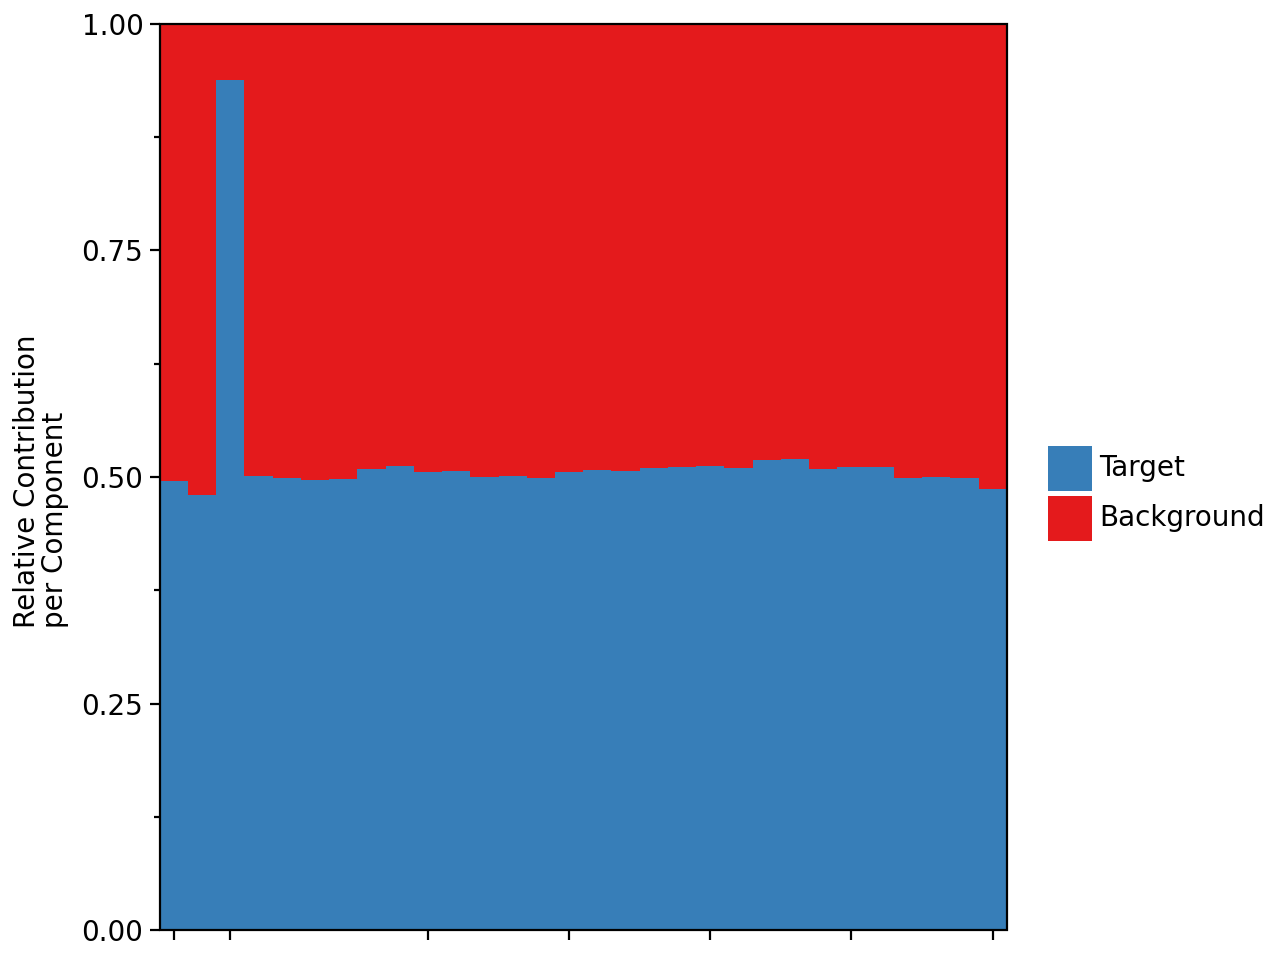

In [57]:
pl_var = (
    ggplot(df_long_summary, aes(x='variable', y='var_ratio', fill='data_id'))
    + geom_bar(stat = "identity", width = 1)
    + scale_y_continuous(expand=(0,0))
    + scale_x_discrete(
        expand=(0,0),
        breaks = ['X0', 'X2', 'X9', 'X14', 'X19', 'X24', 'X29'],
        labels = ['1','3', '10', '15','20','25', '30'])
    + labs(
        fill = "", 
        y = "Relative Contribution \nper Component",
        x = "Principal Component"
    )
    + scale_fill_manual(
        name="",
        breaks=['target', 'background'],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    ) 
    + theme_matplotlib()
    + theme(
        axis_title_x = element_blank(),
        axis_text_x = element_blank()
    )
)

pl_var

In [33]:
df_long_summary['frac_var_expl'] = df_long_summary.groupby('data_id')['var'].transform(lambda x : x / x.sum())

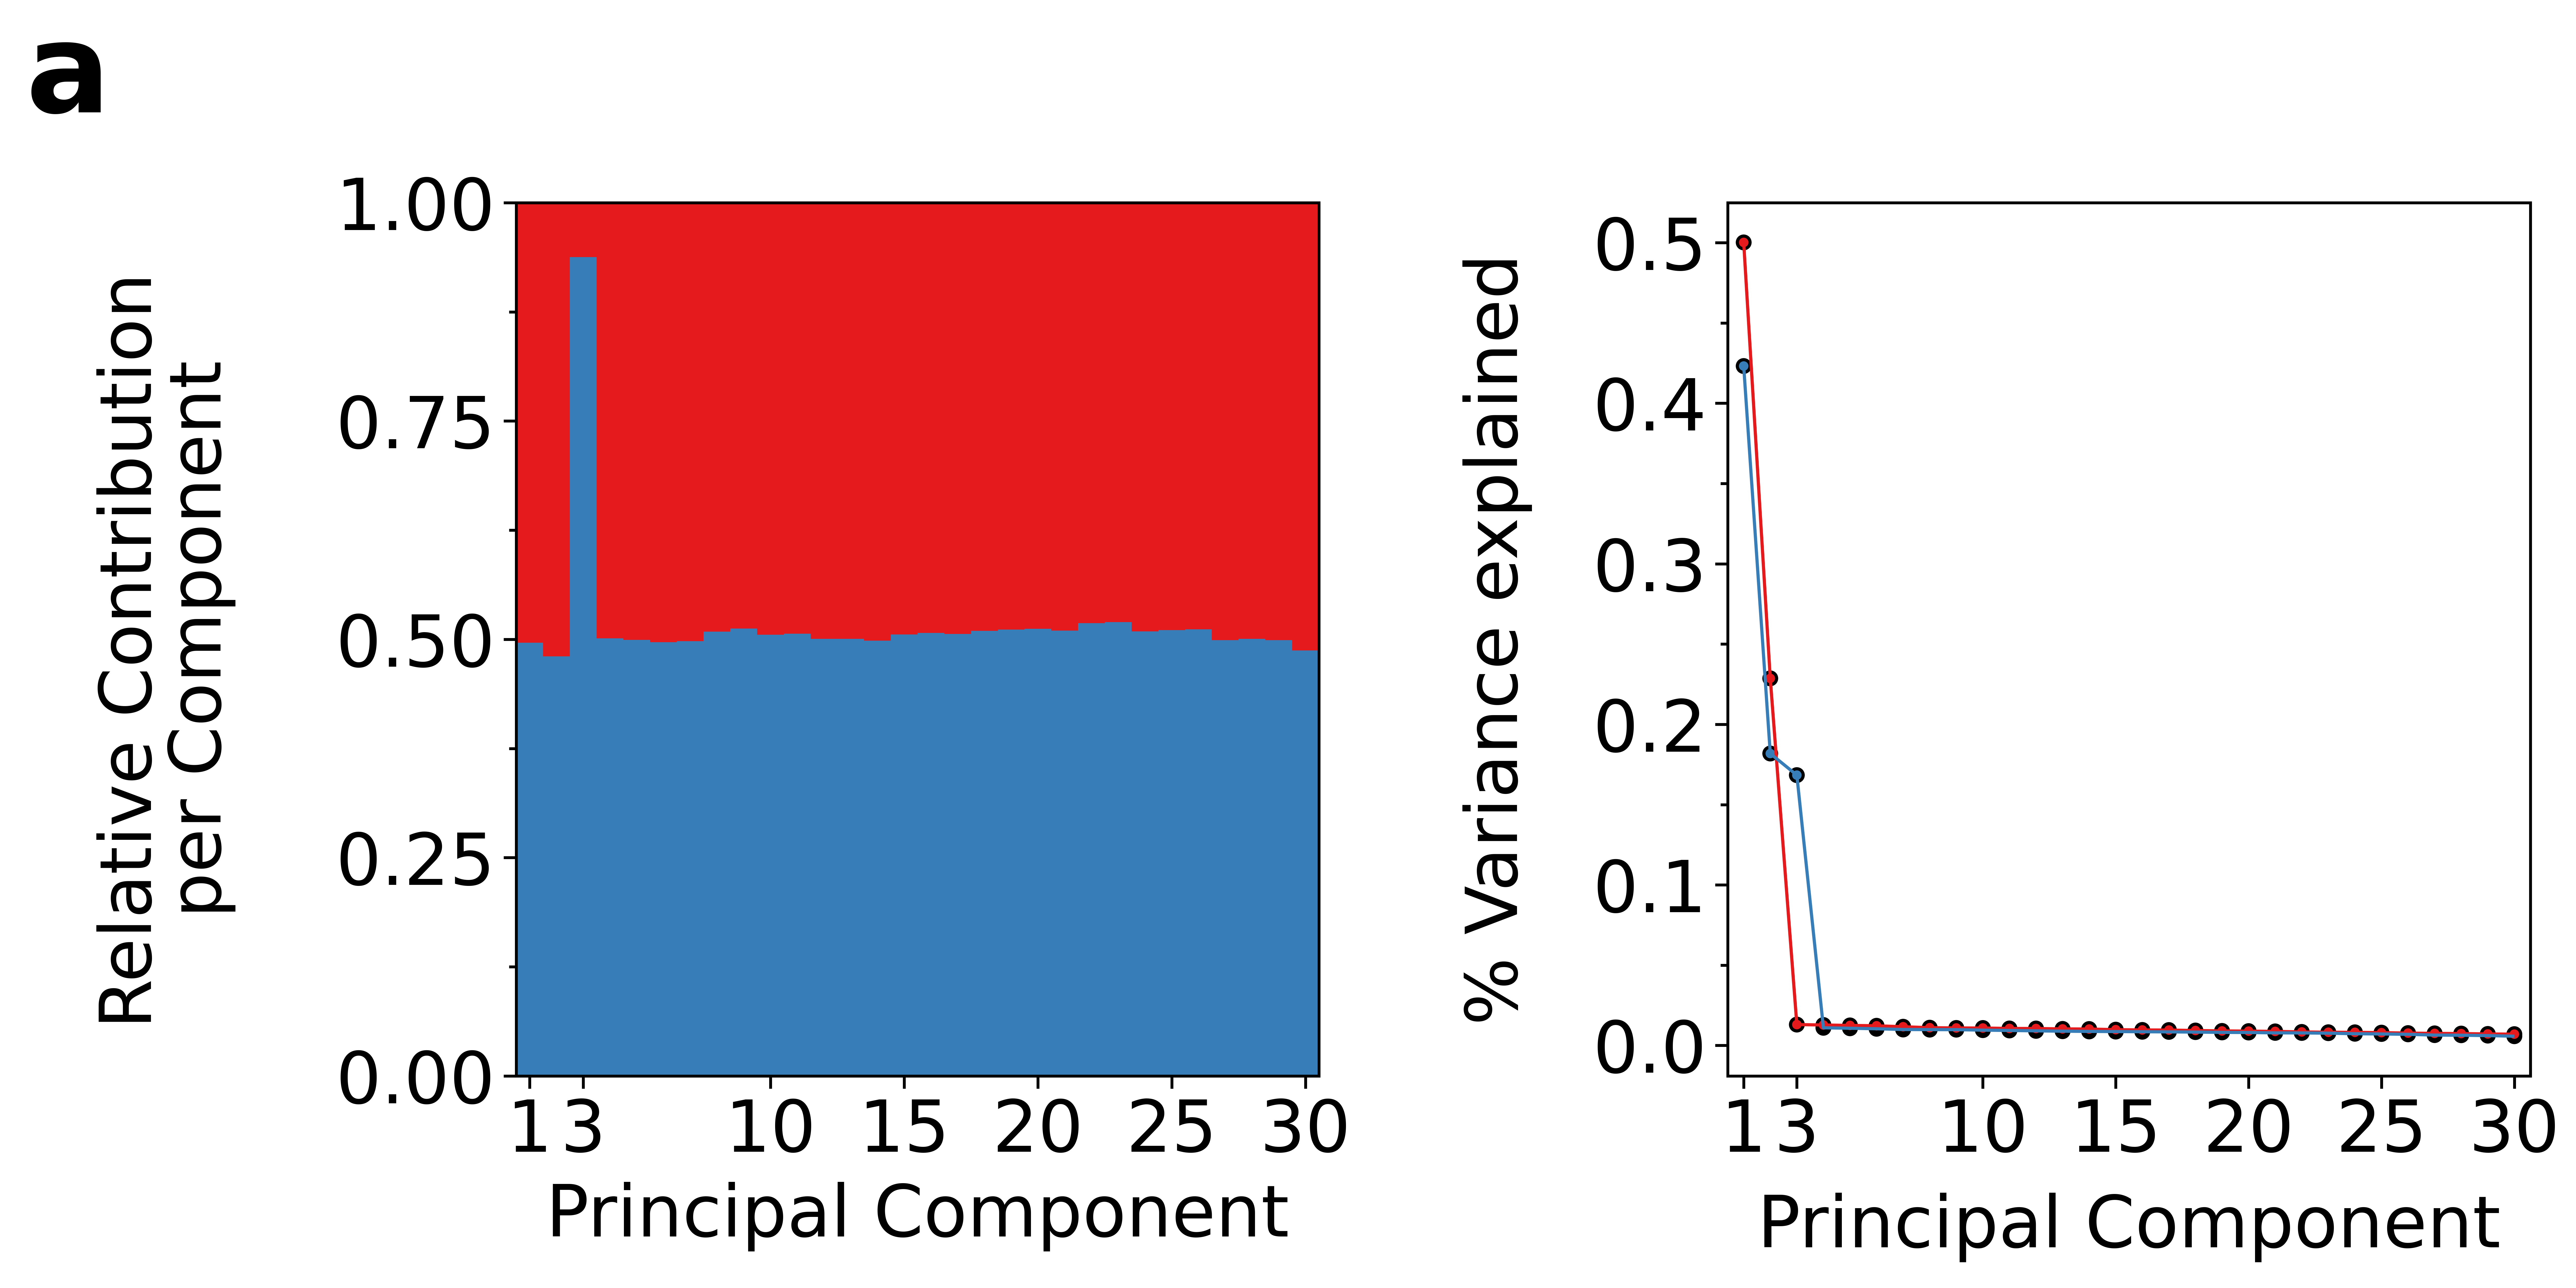

In [125]:
# Fraction variance expl. in blue in each component
pl_scree = (
    ggplot(df_long_summary, aes(x='variable', y='frac_var_expl', fill='data_id', group='data_id'))
    + geom_point()
    + geom_line(mapping=aes(color='data_id'))
    + scale_x_discrete(
        breaks = ['X0', 'X2', 'X9', 'X14', 'X19', 'X24', 'X29'],
        labels = ['1','3', '10', '15','20','25', '30'])
    + labs(
        fill = "", 
        y = "% Variance explained",
        x = "Principal Component"
    )
    + scale_fill_manual(
        name="",
        breaks=['target', 'background'],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    ) 
    + scale_color_manual(
        name="",
        breaks=['target', 'background'],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    ) 
    + theme_matplotlib()
    + theme(
        legend_position = "none",
    )
)

pl_ground_truth = (
    (pl_var 
     + labs(tag='a') 
     + theme(plot_margin_top = 0.01)) |
    (pl_scree + theme(plot_margin_left = 0.05))
)* theme(
        # figure_size=(3.5,6),
        legend_position = "none",
        text = element_text(size=20, ha='center'),
        plot_tag=element_text(
            face='bold',size=35,
            margin={"b": 15, "r": 10,"unit": "pt"}))


pl_ground_truth + theme(figure_size=(10,5), dpi=500)

## Generate Simulation Results
Now, get results for the simulation

In [35]:
results = [
    run_pca_simulation(target, background, method = method, rotations = [0], std_transform=False)
    for method in ['rayleigh', 'cpca']
]

results = pd.concat(results)

results = results.reset_index(drop=True)
results = results.reset_index(names="row_id")

results.head()


Data loaded and preprocessed
Covariance matrices computed


row_id      dim1      dim2              label    method  rotation  \
0       0  4.399425 -1.288935  target_projection  rayleigh         0   
1       1 -6.335081 -1.488140  target_projection  rayleigh         0   
2       2  5.989102 -0.509259  target_projection  rayleigh         0   
3       3 -4.897173  1.678868  target_projection  rayleigh         0   
4       4 -4.887235 -0.627708  target_projection  rayleigh         0   

   is_target data_id  alpha  result_id  
0       True  target -999.0          0  
1       True  target -999.0          0  
2       True  target -999.0          0  
3       True  target -999.0          0  
4       True  target -999.0          0

Remember, for cPCA, when alpha = 0, this is equivalent to doing PCA on the target *only*

In [175]:
def plot_contrastive_results(
    data, x_col, y_col,
    *,
    color_by = 'is_target', 
    color_legend_title = "",
    color_breaks = [True, False],
    color_labels = ["Target", "Background"],
    color_values = ["#377EB8", "#E41A1C"],

    axis_x_title = "GE 1",
    axis_y_title = "GE 2",
    axis_title_hist1 = "GE 1",
    axis_title_hist2 = "GE 2",

    facet_by_hist = "",
    tag_scatter = 'a',

    annotate_scatter = False,
    annotate_x = 0, 
    annotate_y = 0,
    annotate_label = ''
    
): 


    # Base scatter plot
    scatter = (
        ggplot(data, aes(x_col, y_col, color=color_by))
        + geom_point(alpha=0.5)
        + scale_color_manual(
            name=color_legend_title,
            breaks=color_breaks,
            values=color_values,
            labels=color_labels
        )
        + labs(
            x=axis_x_title,
            y=axis_y_title,
            tag=tag_scatter,
        )
        + theme_matplotlib()
        + theme(
            legend_position='none',
            strip_text_x=element_blank(),
            strip_text_y=element_blank(),
            strip_background=element_blank(),
            panel_grid_major=element_line(),
            panel_grid_minor=element_line(),
            panel_ontop=False
        )
    )
    if annotate_scatter: 
        scatter = scatter + annotate(
            'text', 
            x = annotate_x,
            y = annotate_y,
            label = annotate_label,
            ha='left',  # horizontal alignment
            va='top',   
        )

    # Histogram plots
    # Base histogram
    base_hist = (
        ggplot(data, aes(fill='is_target', color='is_target'))
        + scale_color_manual(
            name=color_legend_title,
            breaks=color_breaks,
            values=color_values,
            labels=color_labels
        )
        + scale_fill_manual(
            name=color_legend_title,
            breaks=color_breaks,
            values=color_values,
            labels=color_labels
        )
        + theme_matplotlib()
        + theme(
            legend_position='none',
            strip_text_x=element_blank(),
            strip_text_y=element_blank(),
            strip_background=element_blank(),
            panel_grid_major=element_line(),
            panel_grid_minor=element_line(),
            panel_ontop=False
        )
    )
    
    hist1 = (
        base_hist
        + geom_histogram(
            aes(x=x_col, y=after_stat('density')),
            binwidth=0.45,
            color=None,
            position='identity',
            alpha=0.4
        )
        + geom_density(aes(x=x_col), size=1, fill=None)
        + labs(
            x=axis_title_hist1, 
            y="Density")
    )

    hist2 = (
        base_hist
        + geom_histogram(
            aes(x=y_col, y=after_stat('density')),
            binwidth=0.45,
            color=None,
            position='identity',
            alpha=0.4
        )
        + geom_density(aes(x=y_col), size=1, fill=None)
        + labs(
            x=axis_title_hist2, 
            y="")
    )

    return ((scatter + labs(tag=tag_scatter)) | (hist1 + theme(plot_margin_left=0.02)) | hist2)

In [128]:
grouped = results.groupby(["alpha", "method"])

In [129]:
[name for name, data in grouped]

[(np.float64(-999.0), 'rayleigh'),
 (np.float64(0.0), 'cpca'),
 (np.float64(0.2782559402207124), 'cpca'),
 (np.float64(5.994842503189409), 'cpca'),
 (np.float64(129.15496650148827), 'cpca')]

In [176]:
letters = string.ascii_lowercase
plots = []

for i, (name, data) in enumerate(grouped): 

    tag = letters[i+1]
    
    if i == 0:
        x_title = hist1_title = "GE 1"
        y_title = hist2_title = "GE 2" 
    else: 
        x_title = hist1_title = "cPC 1"
        y_title = hist2_title = "cPC 2"
        

    annot = (i > 0)
    if annot:
         xpos = data['dim1'].min() # + 0.1 * (data['dim1'].max() - data['dim1'].min())
    else: 
        xpos = None
    pl = plot_contrastive_results(
        data, 'dim1', 'dim2', 
        tag_scatter=tag, 
        axis_x_title=x_title, 
        axis_y_title=y_title,
        axis_title_hist1=hist1_title,
        axis_title_hist2=hist2_title,
        annotate_scatter = annot,
        annotate_x = xpos, 
        annotate_y = data['dim2'].max()*1.05,
        annotate_label = fr'$\alpha$ = {name[0]:.2f}'
        )
        
    
    plots.append(pl)

In [131]:
results_var_summary = results.groupby(['method', 'is_target', 'alpha'])[['dim1','dim2']].agg(['var'])

results_var_summary.columns = ['_'.join(map(str, col)).strip() for col in results_var_summary.columns.values]
results_var_summary = results_var_summary.reset_index()
results_var_summary = results_var_summary.pivot(
    index=["method","alpha"], columns="is_target", values=['dim1_var', 'dim2_var']
)

results_var_summary.columns = ['_'.join(map(str, col)).strip() for col in results_var_summary.columns.values]

results_var_summary = results_var_summary.reset_index()
results_var_summary = results_var_summary.assign(
    rho_d1 = lambda x: x.dim1_var_True / x.dim1_var_False,
    rho_d2 = lambda x: x.dim2_var_True/ x.dim2_var_False
)

results_var_summary

method       alpha  dim1_var_False  dim1_var_True  dim2_var_False  \
0      cpca    0.000000       10.704455       9.256137        6.771409   
1      cpca    0.278256        9.690475       9.055248        1.679935   
2      cpca    5.994843        0.370830       4.553186        0.104827   
3      cpca  129.154967        0.103110       0.156375        0.129601   
4  rayleigh -999.000000        1.000000      19.262457        1.000000   

   dim2_var_True     rho_d1    rho_d2  
0       5.939761   0.864700  0.877182  
1       5.210771   0.934448  3.101769  
2       0.131635  12.278353  1.255730  
3       0.363086   1.516588  2.801566  
4       1.543193  19.262457  1.543193

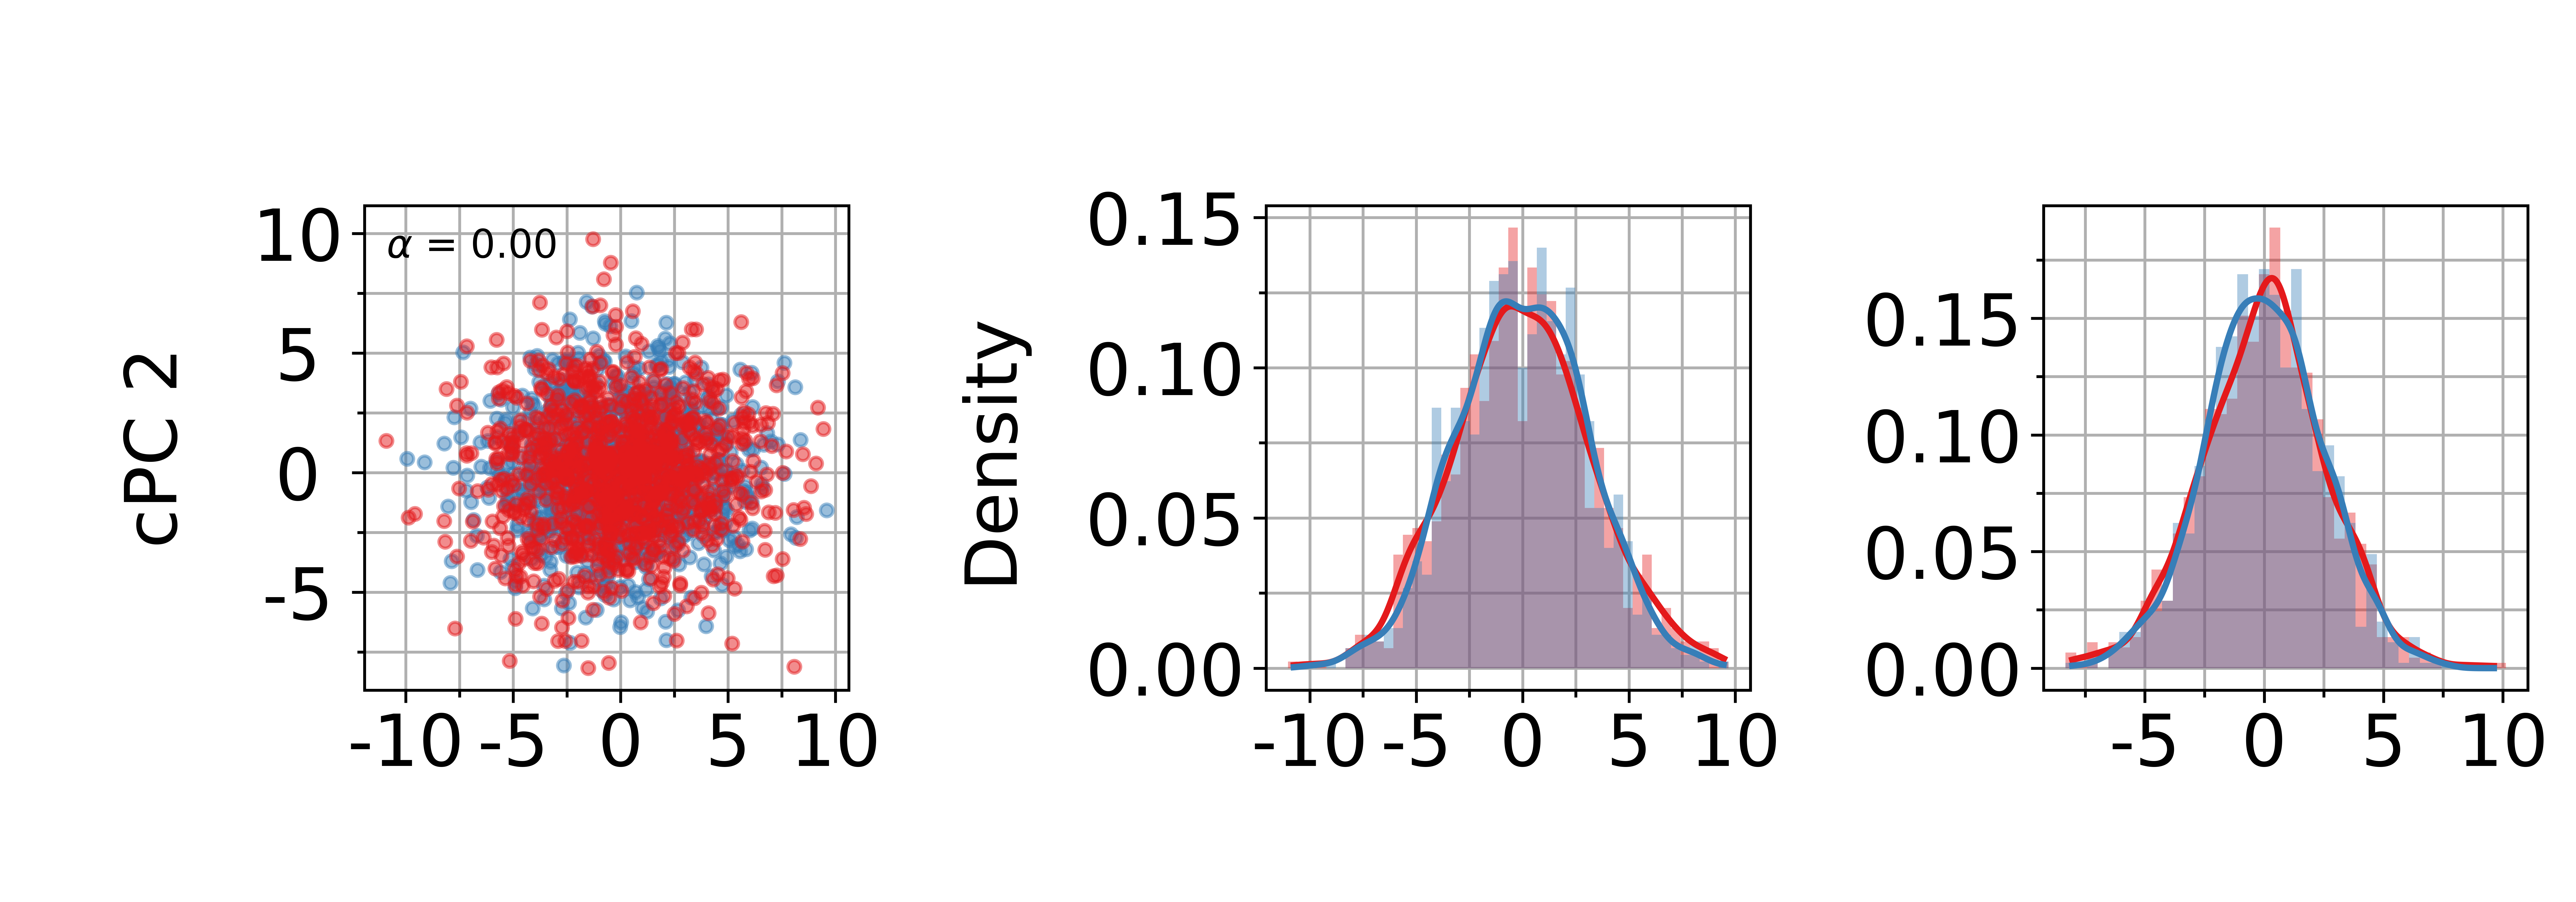

In [182]:
(
    (plots[1])
    & theme(
        legend_position = "none",
        aspect_ratio=1,
        text = element_text(size=20, ha='center'),
        axis_title_x = element_text(color='white'),
        plot_tag=element_text(
            face='bold',size=35,
            color = 'white',
            margin={"b": 15, "r": 10,"unit": "pt"}),
        figure_size=(10,3.5), 
        dpi=500
    )
)

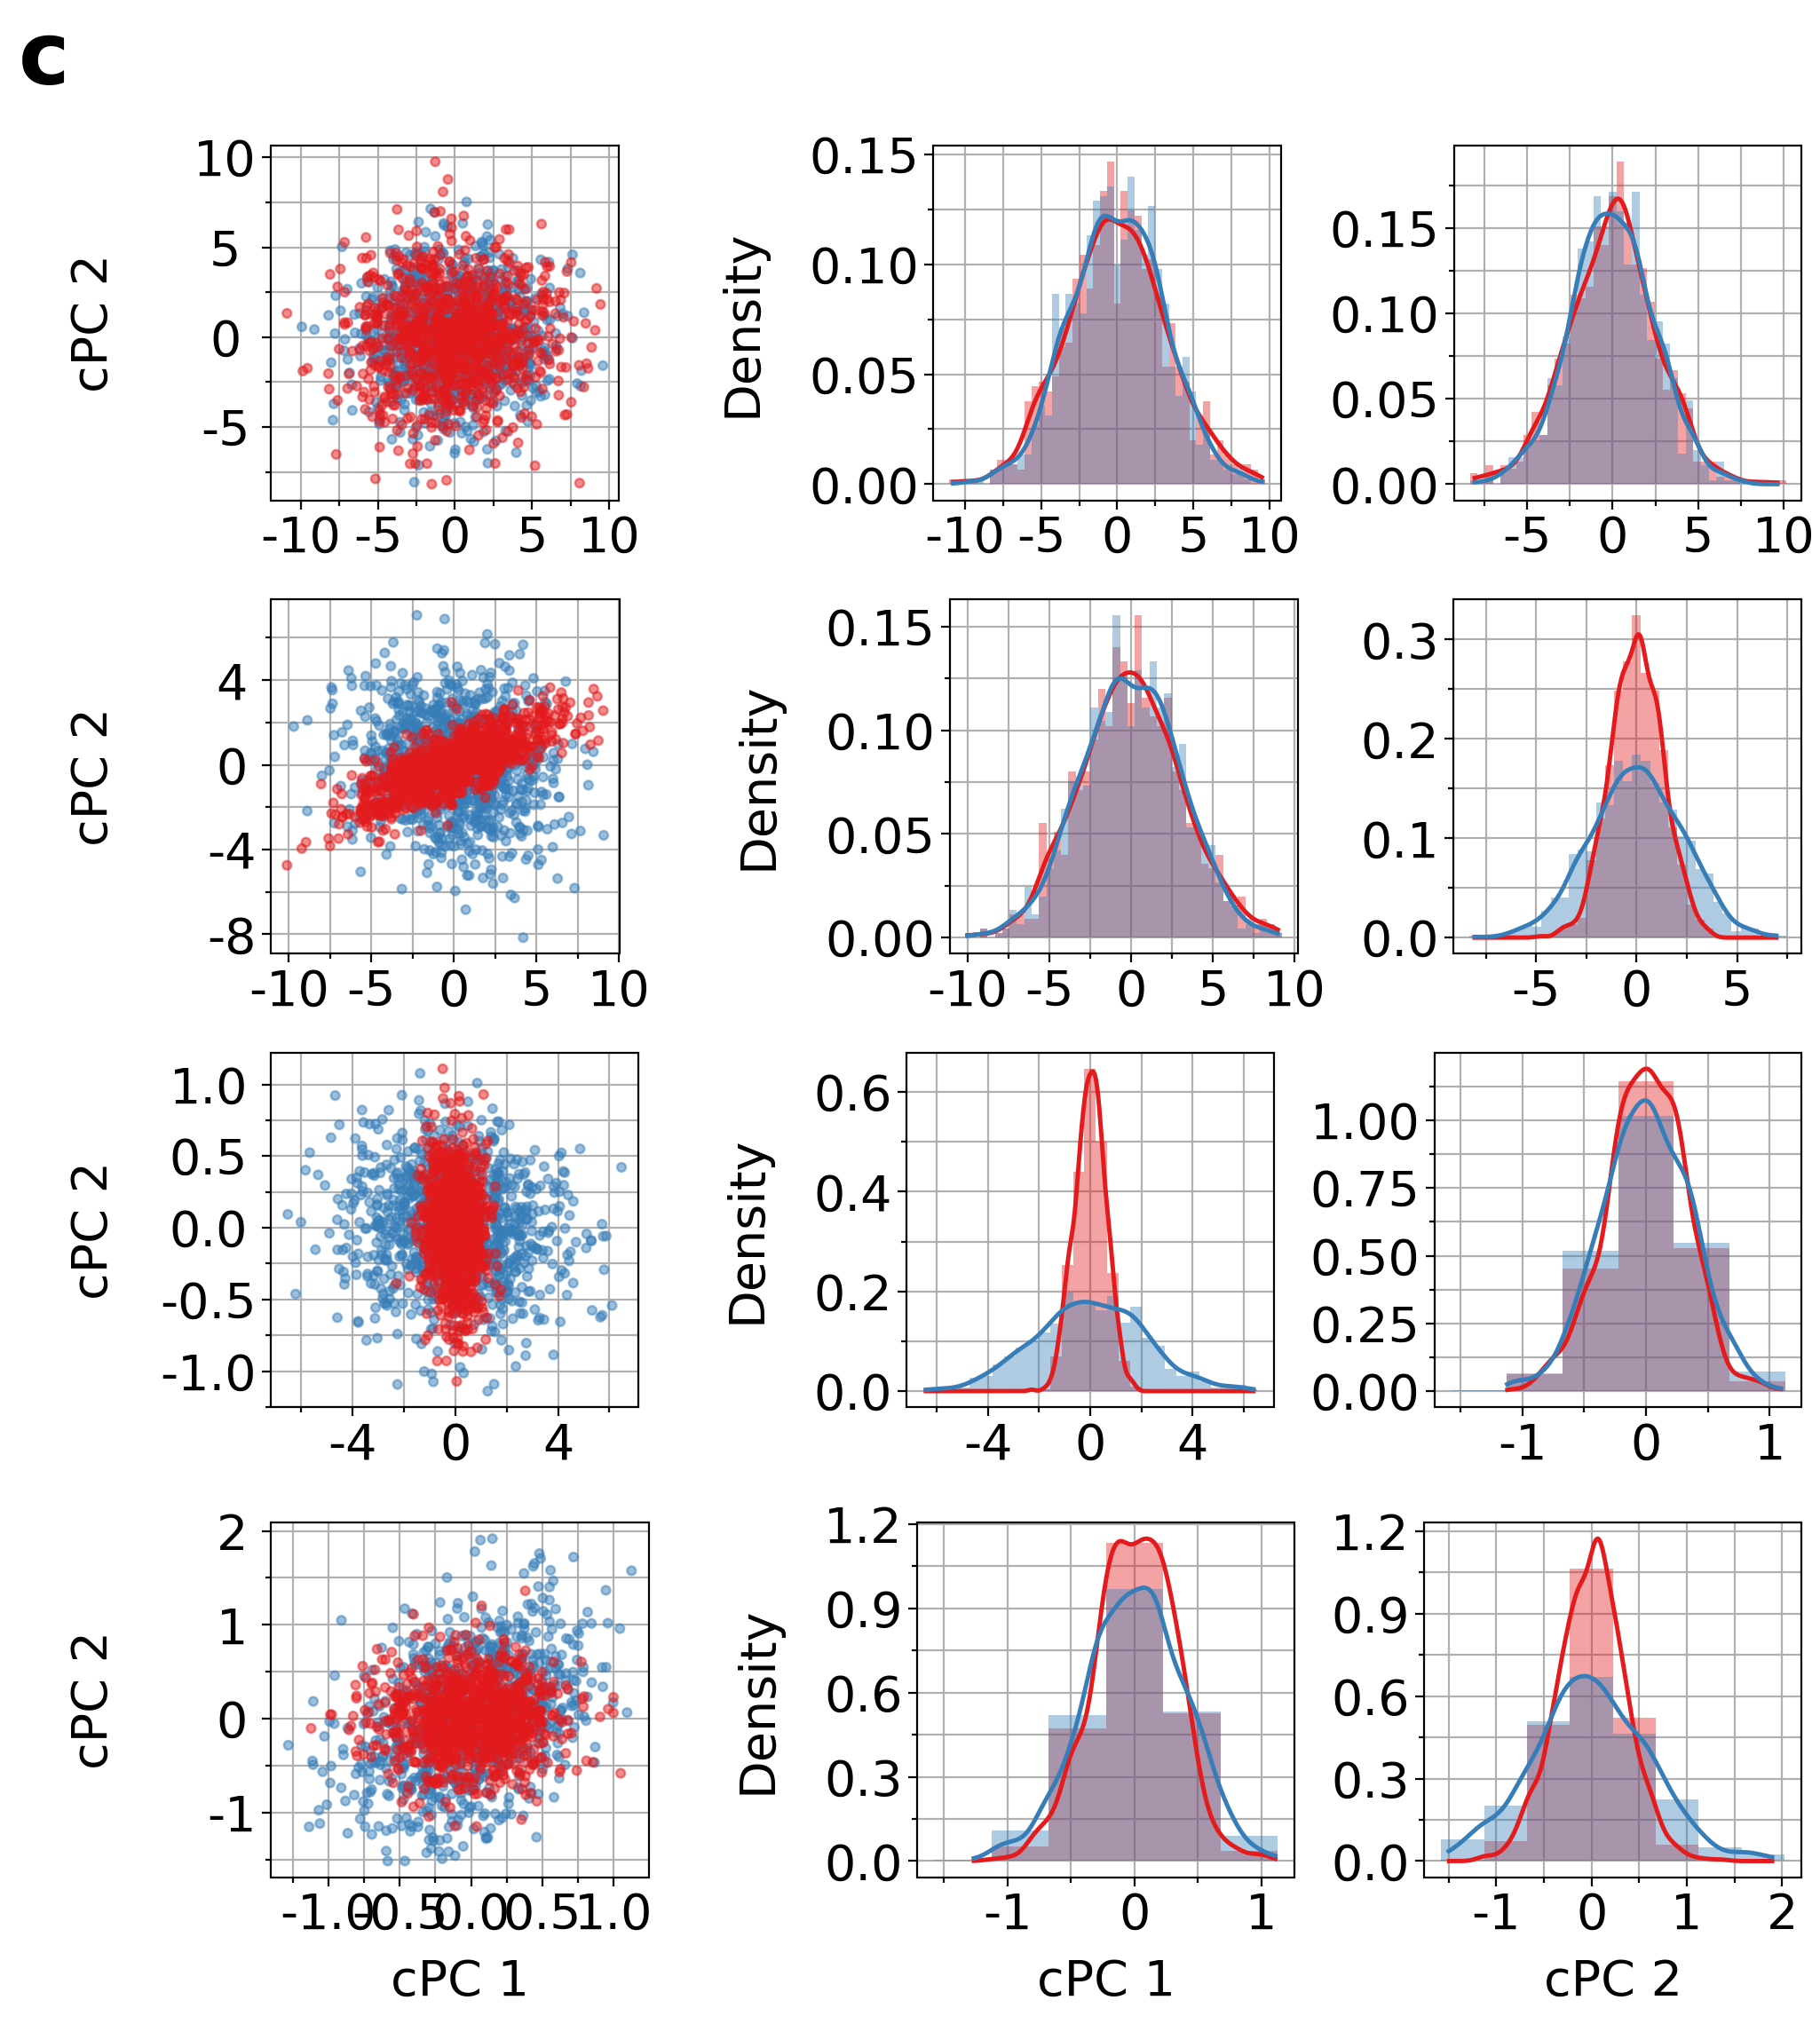

In [109]:
(
    (plots[1]) / 
    (plots[2]) / 
    (plots[3]) /
    (plots[4])
) & theme(
        legend_position = "none",
        text = element_text(size=20, ha='center'),
        plot_tag=element_text(
            face='bold',size=35,
            margin={"b": 15, "r": 10,"unit": "pt"}),
        figure_size=(10.25,2.85*4), 
        dpi=100
    )


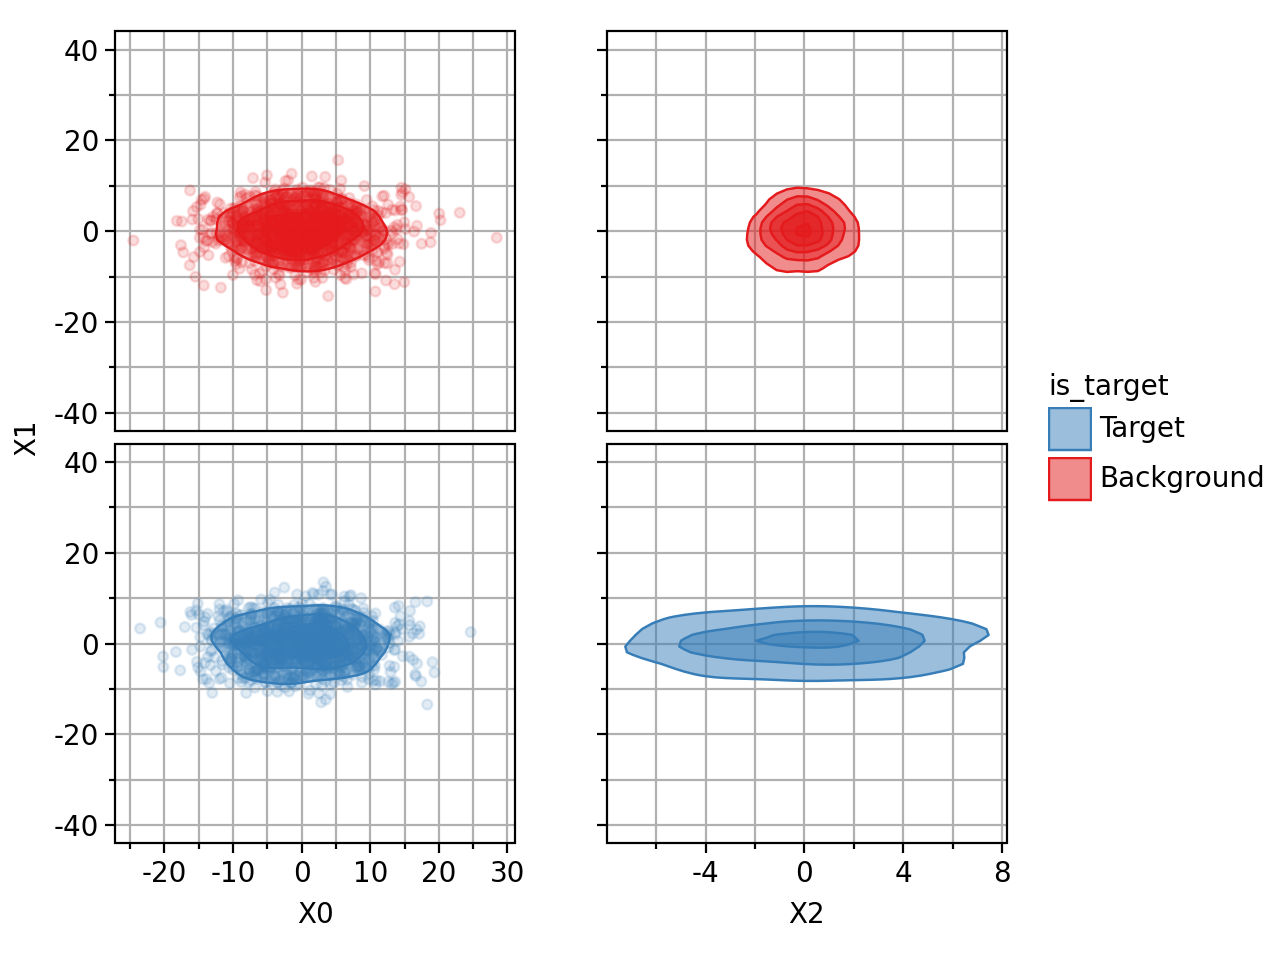

In [26]:
pl_rel1 = (
    ggplot(df, aes('X0', 'X1', color='is_target' ))
    + geom_point(alpha=0.15)
    + stat_density_2d(aes(fill='is_target'), geom='polygon', alpha=0.5)
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + scale_fill_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid("data_id", scales="free")
    #+ coord_fixed(ratio=1)
    + ylim((-40, 40))
    + coord_equal()
    + labs(x="X0", y="X1")
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        panel_ontop=False,
        aspect_ratio=1
    )
)

pl_rel2 = (
    ggplot(df, aes('X2', 'X1', color='is_target'))
    # + geom_point(alpha=0.5)
    + stat_density_2d(aes(fill='is_target'), geom='polygon', alpha=0.5)
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + scale_fill_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid("data_id", scales="free")
    # + coord_fixed(ratio=1)
    + labs(x="X2", y="X1")
    + ylim((-40,40))
    + theme_matplotlib()
    + theme(
        # legend_position='none',
        axis_title_y = element_blank(),
        axis_text_y = element_blank(),
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        panel_ontop=False,
        plot_margin_left=0.05,
        aspect_ratio=1
    )
)

pl_rel1 | pl_rel2

In [20]:
results = [
    run_pca_simulation(target, background, method = method, rotations = [0], std_transform=False)
    for method in ['rayleigh', 'cpca']
]

results = pd.concat(results)
results = results.reset_index(drop=True)

results = results.reset_index(names="row_id")

Data loaded and preprocessed
Covariance matrices computed


In [26]:
results_cpca = results.loc[results.method == 'cpca']

In [111]:
def plot_cpca_facets(data, facet_row, index):
    """
    Generate a multi-panel Plotnine figure 
    df : pandas.DataFrame
        Must contain columns:
        - 'dim1', 'dim2': numeric coordinates
        - 'is_target': boolean or categorical
        - 'result_id': facet identifier

    """

    # Base scatter plot
    scatter = (
        ggplot(data, aes('dim1', 'dim2', color='is_target'))
        + geom_point(alpha=0.5)
        + scale_color_manual(
            name="",
            breaks=[True, False],
            values=["#377EB8", "#E41A1C"],
            labels=["Target", "Background"]
        )
        + facet_grid(rows=facet_row, scales="free")
        + labs(
            x=("GE 1" if index ==3 else ""),
            y="GE 2")
        + theme_matplotlib()
        + theme(
            legend_position='none',
            strip_text_x=element_blank(),
            strip_text_y=element_blank(),
            strip_background=element_blank(),
            panel_grid_major=element_line(),
            panel_grid_minor=element_line(),
            panel_ontop=False,
            aspect_ratio=1
        )
    )

    # Base histogram
    base_hist = (
        ggplot(data, aes(fill='is_target', color='is_target'))
        + scale_color_manual(
            name="",
            breaks=[True, False],
            values=["#377EB8", "#E41A1C"],
            labels=["Target", "Background"]
        )
        + scale_fill_manual(
            name="",
            breaks=[True, False],
            values=["#377EB8", "#E41A1C"],
            labels=["Target", "Background"]
        )
        + facet_grid("result_id ~ .", scales="free")
        + theme_matplotlib()
        + theme(
            legend_position='none',
            strip_text_x=element_blank(),
            strip_text_y=element_blank(),
            strip_background=element_blank(),
            panel_grid_major=element_line(),
            panel_grid_minor=element_line(),
            aspect_ratio=1
        )
    )

    hist1 = (
        base_hist
        + geom_histogram(
            aes(x="dim1", y=after_stat('density')),
            binwidth=0.45,
            color=None,
            position='identity',
            alpha=0.4
        )
        + geom_density(aes(x="dim1"), size=1, fill=None)
        + labs(
            x=("GE 1" if index ==3 else ""), 
            y="Density")
    )

    hist2 = (
        base_hist
        + geom_histogram(
            aes(x="dim2", y=after_stat('density')),
            binwidth=0.45,
            color=None,
            position='identity',
            alpha=0.4
        )
        + geom_density(aes(x="dim2"), size=1, fill=None)
        + labs(
            x=("GE 2"if index ==3 else ""))
        + theme(
            axis_text_y=element_blank(),
            axis_title_y=element_blank()
        )
    )

    # Combine all panels horizontally
    full_plot = (
        (
         scatter |
         #(scatter + labs(tag="a")) |
         (hist1 + theme(plot_margin_left=0.01)) |
         (hist2)
        )
        * theme(figure_size=(10.5, 5))
    )

    return full_plot


In [213]:
fs = [plot_cpca_facets(df, 'result_id', index=i) for i, (name, df) in enumerate(results_cpca.groupby('result_id'))]

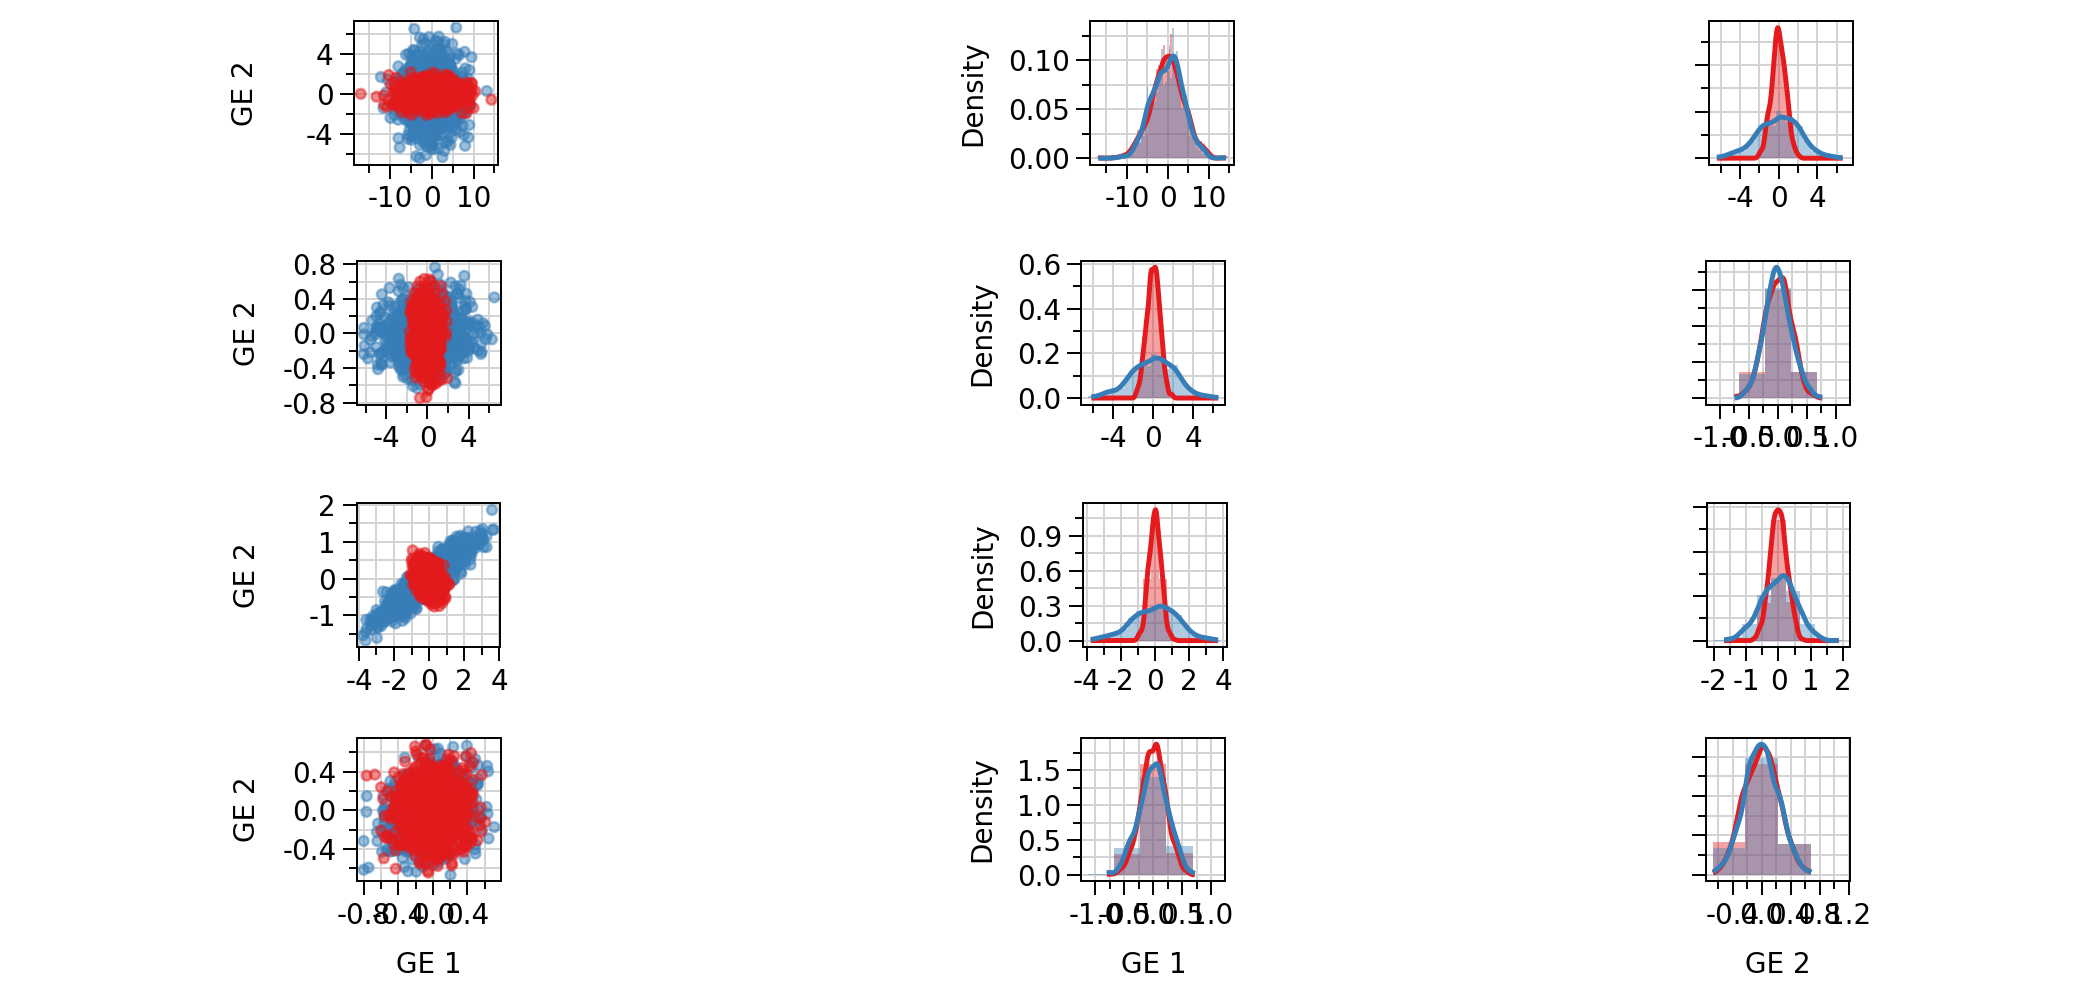

In [214]:
fin = reduce(lambda p1, p2: p1 / p2, fs)
fin # * theme(panel_spacing = -0.03)

In [211]:
f2 = fin.draw()
f2.get_axes()

[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

In [37]:
cpca_sc = (
    ggplot(results_cpca, aes('dim1', 'dim2', color='is_target'))
    + geom_point(alpha=0.5)
    # + coord_fixed(ratio=1)
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid(rows="result_id", scales="free")
    + labs(x="GE 1", y="GE 2")
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        panel_ontop=False,
        aspect_ratio=1
    )
)


base_hist = (
    ggplot(results_cpca, aes(fill='is_target', color='is_target'))
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + scale_fill_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid("result_id ~ .", scales="free")
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        aspect_ratio=1
    )
)

pl_hist_ge1 = (
    base_hist 
    + geom_histogram(
        aes(x="dim1", y=after_stat('density')),
        binwidth=0.5,
        color=None,
        position='identity',
        alpha=0.4
    )
    + geom_density(aes(x="dim1"),size=1, fill=None)
    + labs(x = "GE 1", y = "Density")
)
pl_hist_ge2 = (
    base_hist 
    + geom_histogram(
        aes(x="dim2", y=after_stat('density')),
        binwidth=0.5,
        color=None,
        position='identity',
        alpha=0.4
    )
    + geom_density(aes(x="dim2"),size=1, fill=None)
    + labs(x = "GE 2") +
    theme(
        axis_text_y=element_blank(),
        axis_title_y=element_blank()
    )
)


pl_full = (
    ( 
        (cpca_sc + labs(tag="A")) | 
        (pl_hist_ge1+theme(plot_margin_left=0.03)+labs(tag="B")) | 
        pl_hist_ge2) 
    * theme(
        panel_spacing = 0.03,
        figure_size=(7, 4.5),
    )
)
pl_full

In [209]:
cpca_sc = (
    ggplot(results_cpca, aes('dim1', 'dim2', color='is_target'))
    + geom_point(alpha=0.5)
    # + coord_fixed(ratio=1)
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid('. ~ result_id', scales="free")
    + labs(x="GE 1", y="GE 2")
    + coord_cartesian()
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        panel_ontop=False,
        panel_spacing=0.03,
        aspect_ratio=1
    )
)

# fig = cpca_sc.draw()
# display(fig)

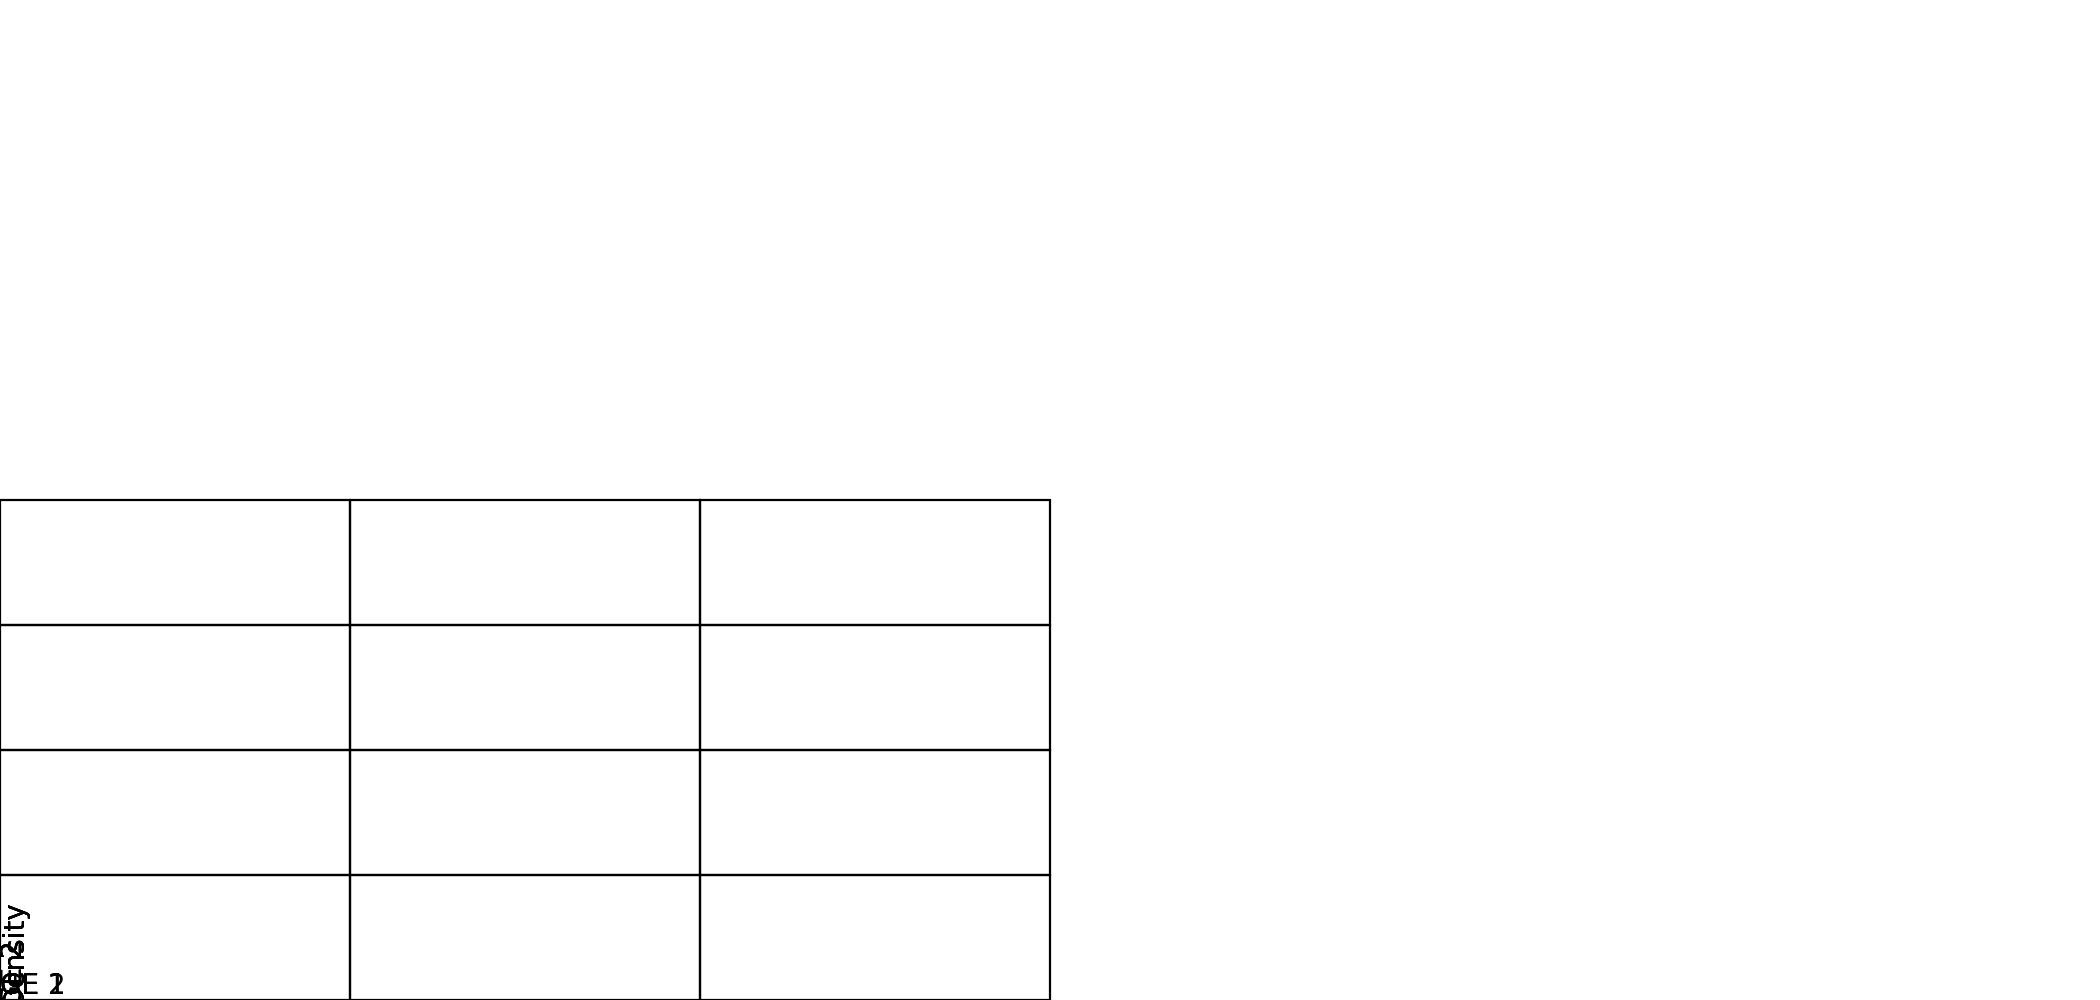

In [212]:
fin

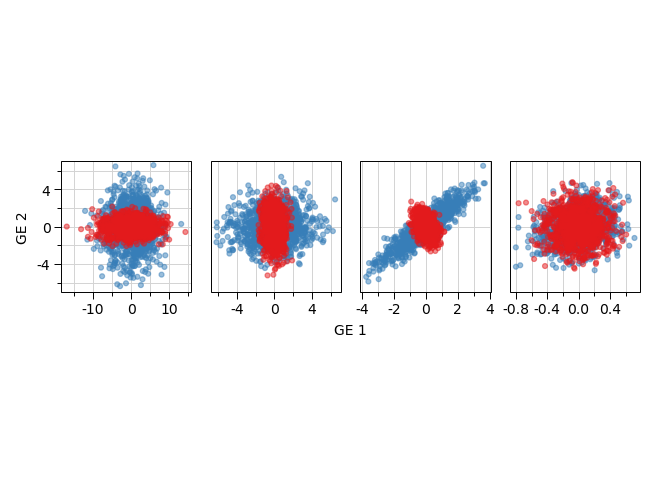

In [210]:
# Now manually adjust y-limits per facet
# mpl_fig = fig._root_figure  # this is a matplotlib.figure.Figure
ylim_dict = {0: (-7, 7), 1: (-1, 1),2: (-2, 2), 3: (-1,1)}

fig = cpca_sc.draw()  # Get underlying matplotlib figure
for i in range(4):
    
    ax = fig.get_axes()[i]
    ax.set_ylim(ylim_dict[i])

# display(fig)  
# fig.canvas.draw()
# fig.show()

display(fig)

In [177]:
def use_theme_matplotlib():
    """
    Apply a Matplotlib style that mimics Plotnine's theme_matplotlib().
    """
    plt.rcParams.update({
        # Backgrounds
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "black",

        # Gridlines
        "axes.grid": True,
        "grid.color": "lightgray",
        "grid.linestyle": "-",
        "grid.linewidth": 0.7,
        "axes.axisbelow": True,  # grid below points

        # Ticks
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.color": "black",
        "ytick.color": "black",
        "xtick.major.size": 5,
        "ytick.major.size": 5,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,

        # Fonts
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],

        # Lines
        "lines.linewidth": 1.5,

        "axes.labelcolor": "black",
        "axes.titlecolor": "black"
    })

import matplotlib.gridspec as gridspec

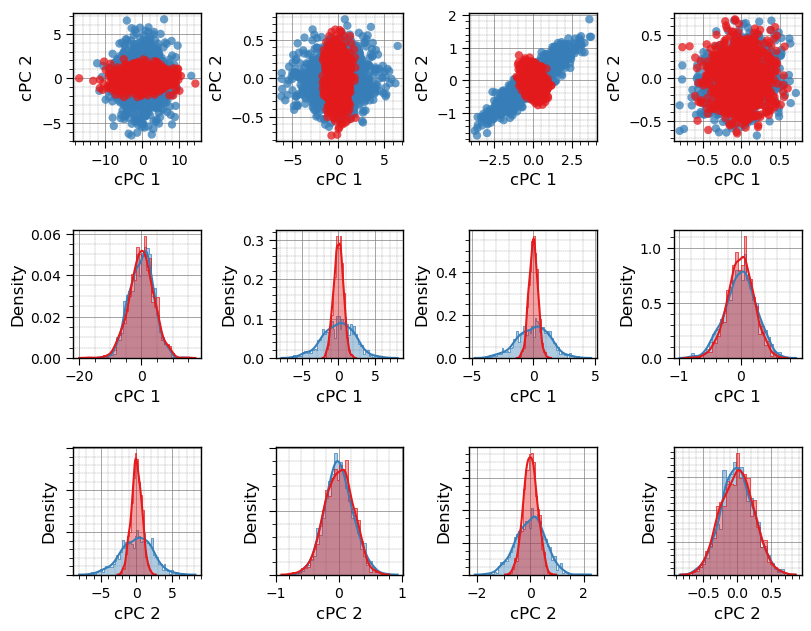

In [145]:

results_cpca['is_target'] = results_cpca['is_target'].astype(bool)
facet_ids = results_cpca['result_id'].unique()
n_facets = len(facet_ids)

# Color palette
palette = {True: "#377EB8", False: "#E41A1C"}

use_theme_matplotlib()
fig, axes = plt.subplots(
    nrows=3, ncols=n_facets, figsize=(2*n_facets, 6.5),
    constrained_layout=True
)

# Make axes 2D array if n_facets == 1
if n_facets == 1:
    axes = axes.reshape(3, 1)

for j, facet_id in enumerate(facet_ids):
    df_facet = results_cpca[results_cpca['result_id'] == facet_id]

    # ----- Scatter plot -----
    ax_sc = axes[0, j]
    for t in [True, False]:
        subset = df_facet[df_facet['is_target'] == t]
        ax_sc.scatter(subset['dim1'], subset['dim2'],
                      color=palette[t], alpha=0.75, edgecolor='none')
    ax_sc.set_box_aspect(1)
    ax_sc.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax_sc.grid(which='minor', color='gray', linestyle='--', linewidth=0.25)
    ax_sc.minorticks_on()
    ax_sc.set_xlabel("cPC1")
    ax_sc.set_ylabel("cPC2")
    # ax_sc.set_title(f"Facet {facet_id}")

    # ----- Histogram GE1 -----
    ax_h1 = axes[1, j]
    sns.histplot(df_facet, x='dim1', hue='is_target', stat='density',
                 element='step', alpha=0.4, palette=palette, ax=ax_h1, legend=False)
    sns.kdeplot(df_facet, x='dim1', hue='is_target', palette=palette, ax=ax_h1, legend=False)
    ax_h1.set_box_aspect(1)
    ax_h1.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax_h1.grid(which='minor', color='gray', linestyle='--', linewidth=0.25)
    ax_h1.minorticks_on()
    ax_h1.set_xlabel("cPC1")
    ax_h1.set_ylabel("Density")

    # ----- Histogram GE2 -----
    ax_h2 = axes[2, j]
    sns.histplot(df_facet, x='dim2', hue='is_target', stat='density',
                 element='step', alpha=0.4, palette=palette, ax=ax_h2, legend=False)
    sns.kdeplot(df_facet, x='dim2', hue='is_target', palette=palette, ax=ax_h2, legend=False)
    ax_h2.set_box_aspect(1)
    ax_h2.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax_h2.grid(which='minor', color='gray', linestyle='--', linewidth=0.25)
    ax_h2.minorticks_on()
    ax_h2.set_xlabel("cPC2")
    ax_h2.set_ylabel("Density")
    ax_h2.set_yticklabels([])

plt.show()


In [ ]:
pl_rel = (
    ggplot(res, aes('dim1', 'dim2', color='is_target'))
    + geom_point(alpha=0.5)
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid("method", scales="free")
    + labs(x="GE 1", y="GE 2")
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        panel_ontop=False,
        aspect_ratio=1
    )
)



base_hist = (
    ggplot(res, aes(fill='is_target', color='is_target'))
    + scale_color_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + scale_fill_manual(
        name="",
        breaks=[True, False],
        values=["#377EB8", "#E41A1C"],
        labels=["Target", "Background"]
    )
    + facet_grid("method ~ .", scales="free")
    + theme_matplotlib()
    + theme(
        legend_position='none',
        strip_text_x=element_blank(),
        strip_text_y=element_blank(),
        strip_background=element_blank(),
        panel_grid_major=element_line(),
        panel_grid_minor=element_line(),
        aspect_ratio=1
    )
)

pl_hist_ge1 = (
    base_hist 
    + geom_histogram(
        aes(x="dim1", y=after_stat('density')),
        binwidth=0.5,
        color=None,
        position='identity',
        alpha=0.4
    )
    + geom_density(aes(x="dim1"),size=1, fill=None)
    + labs(x = "GE 1", y = "Density")
)
pl_hist_ge2 = (
    base_hist 
    + geom_histogram(
        aes(x="dim2", y=after_stat('density')),
        binwidth=0.5,
        color=None,
        position='identity',
        alpha=0.4
    )
    + geom_density(aes(x="dim2"),size=1, fill=None)
    + labs(x = "GE 2") +
    theme(
        axis_text_y=element_blank(),
        axis_title_y=element_blank()
    )
)


In [ ]:
pl_full = (
    ( 
        (pl_rel + labs(tag="A")) | 
        (pl_hist_ge1+theme(plot_margin_left=0.03)+labs(tag="B")) | 
        pl_hist_ge2) 
    * theme(
        panel_spacing = 0.03,
        figure_size=(7, 4.5),
    )
)


In [ ]:
pl_full